In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from random import random
import csv

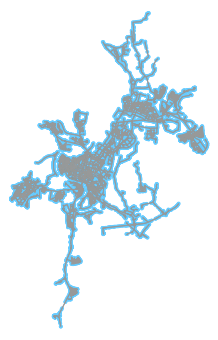

In [2]:
place = {'city' : 'Ufa',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive', simplify=False)

fig, ax = ox.plot_graph(G)

In [3]:
# нахождение расстояний между смежными узлами
a = G.adj
dictionary = {}
i = 0
for key, value in a.items():
    if i == 10:
        break
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']})                  

In [4]:
nodes_list = list(G.nodes())

In [5]:
# вытаскиваем больницы и дома
buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)


hospital = []
apartments = []
n = 10000
build = buildings.head(n)['building'].to_dict()

for key,value in build.items():
    if value == 'hospital':
        hospital.append(key)
    elif value == 'apartments':
        apartments.append(key)

hospitals = hospital[:10]
apartments = apartments[:100]

# print(hospitals)
# print(apartments)

In [6]:
# для каждой больницы и дома находим соответсвующие им (ближайшие) ноды на графе
a = buildings.head(n).to_dict()
hospitals_dict = {}
apartments_dict = {}

for i in hospitals:   
    bounds = a['geometry'][i].bounds
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    hospitals_dict[i] = nearest_node
    # print(i, nearest_node)

for i in apartments:
    bounds = a['geometry'][i].bounds    
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node
    # print(i, nearest_node)

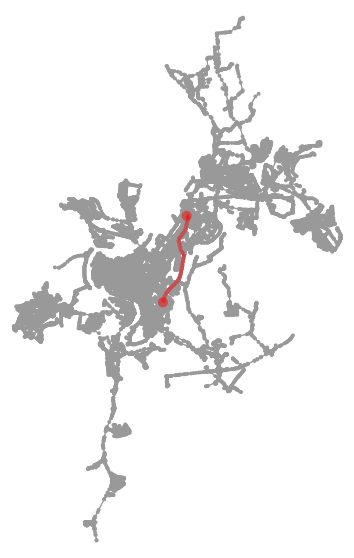

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x204f37fccd0>)

In [7]:
# пример визуализации кратчайших путей
route = nx.shortest_path(G,
                         892683760,
                         498826321, 
                         weight='length') 

ox.plot_graph_route(G, route, fig_height=10, fig_width=10)

In [8]:
# матрица смежностти в пандас
G_pd = nx.to_pandas_adjacency(G)

# можно записать в эксель и это даже работает!!
G_pd.to_csv('matrix_adjacency_pandas.csv')

In [9]:
# запускать только один раз
G_pd = G_pd.values

In [10]:
print(G_pd)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
# пишем полученный ndarray в csv
with open('matrix_adjacency.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in G_pd:
        writer.writerow(line)

In [12]:
# вместо нулей и единиц записываем в матрицу смежности расстояния между нодами (по формуле из файла)
for i in range(len(G_pd)):
    for j in range(len(G_pd)):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]   
            weight = 1
            if nodes_list[i] in hospitals_dict.values():
                weight = random() + 1
            G_pd[i][j] = distance * weight
# если ребра между нодами нет, то заполняем большими расстояниями (для нахождения крастчайших путей)
# возможно, можно придумать что-то менее костыльное
        if G_pd[i][j] == 0:
            G_pd[i][j] = 10**10

In [13]:
# Создаем словарь {id узла}: {его index в списке узлов}
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index 

In [14]:
# алгоритм Дейкстры поиска кратчайших путей
def dijkstra(N, S, matrix, pred):
    valid = [True]*N
    weight = [1000000]*N
    weight[S] = 0
    for i in range(N):
        min_weight = 1000001
        ID_min_weight = -1
        for j in range(N):
            if valid[j] and weight[j] < min_weight:
                min_weight = weight[j]
                ID_min_weight = j
                for z in range(N):
                    if weight[ID_min_weight] + matrix[ID_min_weight][z] < weight[z]:
                        weight[z] = weight[ID_min_weight] + matrix[ID_min_weight][z]
                        pred[z] = ID_min_weight
        valid[ID_min_weight] = False
    return weight

In [15]:
# делаем листы для использования Дейсктры 
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())

In [16]:
# создаем общий лист, чтобы сделать и квартиры, и больницы одновременно
new_nodes = apartments_values + hospital_values

In [17]:
# матрица в которой будем хранить значения кратчайших путей
short_path_matrix = np.zeros((len(new_nodes), len(new_nodes)))

# словарь, который хранит дерево кратчайших расстояний из вершины i
pred_dict = {}

index_nodes = [] # индексы узлов домов
for i in new_nodes:
    index_nodes.append(nodes_numbers[i]) # в качестве индекса номер, соответствующий id узла

In [ ]:
# поиск кратчайших путей (по расстоянию, если что (а то там был варик по времени поездки))
# пункт 1.1
for i in range(len(new_nodes)):
    pred = {}
    index = index_nodes[i]
    distance = dijkstra(len(G_pd), index, G_pd, pred)
    pred_dict[index] = pred
    for j in range(len(new_nodes)):
        short_path_matrix[i][j] = distance[index_nodes[j]]

        
print(short_path_matrix)